<a href="https://colab.research.google.com/github/muraliRoyal1/venkatasiva_INFO5731_Fall2020/blob/master/Copy_of_In_class_exercise_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [1]:
#required libraries
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 1.6MB 5.3MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=21b86dd793cea285505c82f261eb194a0f654b491442bab22eba40f02d75d893
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [2]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
name = [ ]
data = [ ]
page_number = [0,10,20,30,40,50,60,70,80,90]
for i in page_number:
  page = requests.get('https://citeseerx.ist.psu.edu/search;jsessionid=87FF6C66EA09F22314C131669600CF98?q=natural+language+processing&t=doc&sort=rlv&start='+ str (i))
  soup = BeautifulSoup(page.content,'html.parser')
  name.append(soup.find_all('a',class_='remove doc_details'))

for j in name:
  for k in range(len(j)):
    data.append(j[k].get_text())



# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]



<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<input>:16: DeprecationWarning: invalid escape sequence \s
<ipython-input-3-d63996e622fc>:16: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent

In [4]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#print(data_words)

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['foundations', 'of', 'statistical', 'natural', 'language', 'processing']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['foundation', 'statistical', 'natural', 'language', 'processing']]


In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


In [9]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('foundation', 1),
  ('language', 1),
  ('natural', 1),
  ('processing', 1),
  ('statistical', 1)]]

In [10]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [11]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.157*"natural" + 0.157*"language" + 0.157*"processing" + '
  '0.044*"application" + 0.044*"ant" + 0.044*"confidence" + 0.044*"nltk" + '
  '0.044*"structure" + 0.044*"use" + 0.044*"learn"'),
 (1,
  '0.080*"structure" + 0.080*"web" + 0.080*"model" + 0.080*"base" + '
  '0.074*"complexity" + 0.067*"natural" + 0.066*"language" + '
  '0.066*"processing" + 0.004*"multitask" + 0.004*"neural"'),
 (2,
  '0.167*"issue" + 0.086*"software" + 0.086*"engineer" + 0.086*"current" + '
  '0.046*"natural" + 0.045*"language" + 0.045*"processing" + 0.004*"multitask" '
  '+ 0.004*"coverage" + 0.004*"process"'),
 (3,
  '0.274*"processing" + 0.274*"language" + 0.269*"natural" + 0.016*"learn" + '
  '0.011*"logic" + 0.010*"use" + 0.010*"tool" + 0.010*"plan" + '
  '0.010*"recognition" + 0.006*"complexity"'),
 (4,
  '0.189*"language" + 0.189*"processing" + 0.189*"natural" + 0.063*"retrieval" '
  '+ 0.032*"machine" + 0.032*"learn" + 0.016*"toolkit" + 0.016*"biomedical" + '
  '0.016*"commercial" + 0.016*"ap

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.120779107429169


/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for


Coherence Score:  0.6223852408401546


In [13]:
!wget "http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip"
!unzip "/content/mallet-2.0.8.zip"

--2020-10-23 02:01:23--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  12.4MB/s    in 1.2s    

2020-10-23 02:01:25 (12.4 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  /content/mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/te

In [14]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


[(15,
  [('natural', 0.8095238095238095),
   ('probabilistic', 0.047619047619047616),
   ('learn', 0.047619047619047616),
   ('semantic', 0.047619047619047616),
   ('adaptive', 0.047619047619047616),
   ('robust', 0.0),
   ('programming', 0.0),
   ('multitask', 0.0),
   ('broad', 0.0),
   ('neural', 0.0)]),
 (8,
  [('processing', 0.9166666666666666),
   ('teaching', 0.041666666666666664),
   ('statistical', 0.041666666666666664),
   ('neural', 0.0),
   ('adaptive', 0.0),
   ('coverage', 0.0),
   ('programming', 0.0),
   ('multitask', 0.0),
   ('thoughttreasure', 0.0),
   ('process', 0.0)]),
 (0,
  [('processing', 0.7),
   ('compute', 0.05),
   ('education', 0.05),
   ('coverage', 0.05),
   ('tribulation', 0.05),
   ('overview', 0.05),
   ('robust', 0.05),
   ('context', 0.0),
   ('thoughttreasure', 0.0),
   ('broad', 0.0)]),
 (1,
  [('natural', 0.625),
   ('logic', 0.08333333333333333),
   ('neural', 0.08333333333333333),
   ('robotic', 0.041666666666666664),
   ('programming', 0.04166

In [16]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [17]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


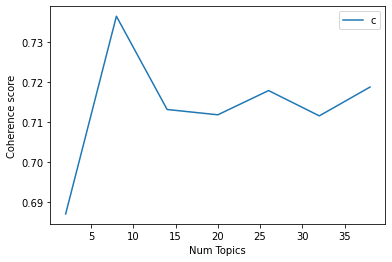

In [18]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.687
Num Topics = 8  has Coherence Value of 0.7365
Num Topics = 14  has Coherence Value of 0.7132
Num Topics = 20  has Coherence Value of 0.7118
Num Topics = 26  has Coherence Value of 0.7179
Num Topics = 32  has Coherence Value of 0.7116
Num Topics = 38  has Coherence Value of 0.7188


In [20]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.720*"natural" + 0.080*"neural" + 0.040*"develop" + 0.040*"logic" + '
  '0.040*"processing" + 0.040*"plan" + 0.040*"deep" + 0.000*"broad" + '
  '0.000*"coverage" + 0.000*"programming"'),
 (1,
  '0.826*"processing" + 0.043*"probabilistic" + 0.043*"deep" + 0.043*"map" + '
  '0.043*"organizing" + 0.000*"process" + 0.000*"coverage" + '
  '0.000*"programming" + 0.000*"thoughttreasure" + 0.000*"multitask"'),
 (2,
  '0.143*"recognition" + 0.071*"adaptive" + 0.071*"speech" + 0.071*"study" + '
  '0.071*"system" + 0.071*"base" + 0.071*"parse" + 0.071*"commercial" + '
  '0.071*"multitask" + 0.071*"language"'),
 (3,
  '0.700*"natural" + 0.033*"structure" + 0.033*"historical" + 0.033*"group" + '
  '0.033*"transducer" + 0.033*"software" + 0.033*"visual" + 0.033*"complexity" '
  '+ 0.033*"limitation" + 0.033*"entropy"'),
 (4,
  '0.667*"processing" + 0.095*"statistical" + 0.048*"triumph" + 0.048*"speech" '
  '+ 0.048*"workbench" + 0.048*"robust" + 0.048*"broad" + 0.000*"neural" + '
  '0.000*"

In [21]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,19.0,0.0677,"language, survey, computer, lyric, section, fo...",Foundations of statistical natural language p...
1,1,7.0,0.0685,"processing, approach, process, thesauruse, tri...",A Maximum Entropy approach to Natural Languag...
2,2,8.0,0.0556,"language, relate, introduction, neural, proces...",Natural Language Processing
3,3,19.0,0.0556,"language, survey, computer, lyric, section, fo...",Linguistics and Natural Language Processing
4,4,3.0,0.0556,"natural, structure, historical, group, transdu...",Natural Language Processing
5,5,11.0,0.0607,"language, machine, retrieval, complexity, lear...",Natural language processing (almost) from scr...
6,6,1.0,0.0535,"processing, probabilistic, deep, map, organizi...",Natural language processing
7,7,12.0,0.0607,"system, semantic, retrieval, lexicon, robotic,...",Natural Language Processing/Robotics
8,8,0.0,0.0556,"natural, neural, develop, logic, processing, p...",Tutorial on Natural Language Processing
9,9,6.0,0.0669,"natural, education, infrastructure, web, base,...",Ambiguities in Natural Language Processing


In [22]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.0828,"natural, neural, develop, logic, processing, p...",A unified architecture for natural language p...
1,1.0,0.0838,"processing, probabilistic, deep, map, organizi...",Self-Organizing Maps In Natural Language Proc...
2,2.0,0.0780,"recognition, adaptive, speech, study, system, ...",Transformation-Based Error-Driven Learning an...
3,3.0,0.0677,"natural, structure, historical, group, transdu...",on Visual Tools for Natural Language Processing
4,4.0,0.0634,"processing, statistical, triumph, speech, work...",Teaching Applied Natural Language Processing:...


In [23]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,19.0,"language, survey, computer, lyric, section, fo...",6.0,0.06
1.0,7.0,"processing, approach, process, thesauruse, tri...",7.0,0.07
2.0,8.0,"language, relate, introduction, neural, proces...",6.0,0.06
3.0,19.0,"language, survey, computer, lyric, section, fo...",8.0,0.08
4.0,3.0,"natural, structure, historical, group, transdu...",6.0,0.06
...,...,...,...,...
95.0,17.0,"processing, tool, transformation, parallelism,...",NaN,NaN
96.0,6.0,"natural, education, infrastructure, web, base,...",NaN,NaN
97.0,2.0,"recognition, adaptive, speech, study, system, ...",NaN,NaN
98.0,13.0,"natural, memory, description, model, issue, le...",NaN,NaN


## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [24]:
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt


In [25]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
preprocess_data(data)

[['foundat', 'statist', 'natur', 'languag', 'process'],
 ['maximum', 'entropi', 'approach', 'natur', 'languag', 'process'],
 ['natur', 'languag', 'process'],
 ['linguist', 'natur', 'languag', 'process'],
 ['natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'almost', 'scratch'],
 ['natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'robot'],
 ['tutori', 'natur', 'languag', 'process'],
 ['ambigu', 'natur', 'languag', 'process'],
 ['statist', 'natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'inform', 'retriev'],
 ['natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'lyric'],
 ['transform',
  'base',
  'error',
  'driven',
  'learn',
  'natur',
  'languag',
  'process',
  'case',
  'studi',
  'part',
  'speech',
  'tag'],
 ['connectionist', 'natur', 'languag', 'process'],
 ['chao', 'natur', 'languag', 'process'],
 ['natur', 'languag', 'process'],
 ['natur', 'languag', 'process', 'introduct'],
 ['overview', 'natur', 'languag', 'process

In [26]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix


In [27]:
number_of_topics=7
words=10

In [28]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


In [29]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [30]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

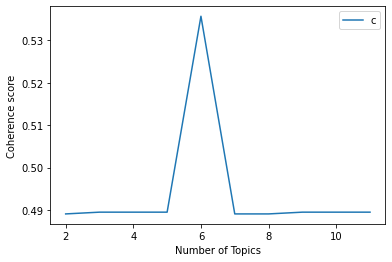

In [31]:
start,stop,step=2,12,1
plot_graph(preprocess_data(data),start,stop,step)

In [32]:
# Write your code here
model=create_gensim_lsa_model(preprocess_data(data),number_of_topics,words)


[(0, '0.580*"languag" + 0.572*"process" + 0.565*"natur" + 0.067*"learn" + 0.040*"retriev" + 0.035*"inform" + 0.029*"use" + 0.028*"system" + 0.023*"overview" + 0.022*"statist"'), (1, '-0.625*"learn" + 0.417*"retriev" + 0.385*"inform" + 0.213*"use" + -0.148*"comput" + -0.127*"assist" + -0.126*"deep" + -0.109*"speech" + -0.109*"base" + -0.105*"error"'), (2, '0.523*"retriev" + 0.490*"inform" + 0.455*"learn" + 0.223*"use" + 0.101*"case" + 0.101*"driven" + 0.101*"error" + 0.101*"transform" + 0.101*"studi" + 0.101*"part"'), (3, '0.320*"base" + 0.306*"speech" + 0.264*"tag" + 0.264*"transform" + 0.264*"part" + 0.264*"driven" + 0.264*"studi" + 0.264*"error" + 0.264*"case" + -0.231*"network"'), (4, '0.717*"system" + 0.360*"evalu" + 0.241*"overview" + 0.180*"relat" + 0.180*"lolita" + 0.146*"histor" + 0.142*"toward" + 0.142*"adapt" + 0.142*"context" + -0.133*"network"'), (5, '-0.449*"network" + -0.364*"neural" + 0.291*"assist" + -0.272*"deep" + -0.265*"architectur" + -0.265*"multitask" + -0.265*"un

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)
'''Topic Modelling can be evaluated by the concept of Topic Coherence.There are many techniques that are used to obtain topic models.They are: 
 Latent Semantic Analysis(LSA) and Latent Dirichlet Allocation (LDA) .
LDA:
The two main inputs to the LDA topic model are the dictionary and the corpus. Gensim creates a unique id for each word in the document.In addition to the corpus and dictionary, we need to provide the number of topics as well.
We can use LDA visualization tool pyLDAvis, by trying a few numbers of topics and comparing the results.Topic coherence is one of the main techniques used to estimate the number of topics.
We need to build many LDA models with different values of the number of topics (k) and pick the one that gives the highest coherence value. Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics.
The  plot of coherence value and number of topics shows that coherence score decreases with the number of topics.Optimum topics score is observed at 10.
and also coherence value observed for the data using LDA algorithm is 0.62

LSA:
LSA is typically used as a dimension reduction or noise reducing technique.
The best way to determine k (number of topics) in topic modeling, is by using Topic coherence measure which is a realistic measure for identifying the number of topics.The high value of topic coherence score model will be considered as a good topic model.
For the Plot i.e.,coherence value and number of topics using LSA algorithm the Optimum coherence score is observed at 0,54 with topic at 6.

So from the analysis, LDA gives better results than LSA .